# **Решение дифференциальных уравнений нейронными сетями**

In [12]:
import shutil
from pathlib import Path

import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as anim
import numpy as np

from NN_pytorch_BVP.bvp import *
from NN_pytorch_BVP.training import *

def prepare_results_dir(res_dir_list: list[str]) -> Path:
    ## Get the script/notebook directory
    #try:                          
    #    ROOT = Path(__file__).resolve().parent    # Regular .py file or module
    #except NameError:                             # __file__ is undefined in notebooks
    #    ROOT = Path.cwd()                         # Jupyter sets cwd to the notebook’s directory
    ROOT = Path.cwd() / 'runs'

    # Create the directory if it does no exist
    dir_list = [ROOT / item for item in res_dir_list]
    for d in dir_list:
        d.mkdir(exist_ok=True)

    # Choose the directory with the oldest modification time
    oldest_dir = min(dir_list, key=lambda p: p.stat().st_mtime)

    # Remove the contents of the chosen directory
    for item in oldest_dir.iterdir():
        if item.is_dir():
            shutil.rmtree(item)
        else:
            item.unlink()
    return oldest_dir


#my_bvp = ODE1D_Phillipov756_Altered([0.0, torch.pi], scheme='uniform')
#my_bvp = HarmonicOscillatorUnderdamped1D([0.0, 1.0], scheme='uniform')
#my_bvp = HeatEquation1D_Pozharsky47_5([0.0, torch.pi/2.0], [0.0, 2.0 * torch.pi], scheme='uniform')
#my_bvp = HeatEquation2D_Pozharsky17([0.0, 0.0, torch.pi, torch.pi], [0.0, 1.0], scheme='uniform')
#my_bvp = HeatEquationCircle_Bogolubov212_5([0.0, 0.0, 5.0, 2.0 * torch.pi], [0.0, 10.0], scheme='uniform')
#my_bvp = HeatEquation2D_Pozharsky50_3( [0, 0, torch.pi, torch.pi], [0.0, 1.0], scheme='uniform' )
#my_bvp = HeatEquation1D_Wang([0.0, 1.0], [0.0, 1.0], scheme='uniform', gamma=10.0)
my_bvp = HeatEquation2D_Custom1([0.0, 0.0, 1.0, 1.0], [0.0, 2.0], scheme='uniform')

# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЕ И ЕГО ЗАПУСК ---
device = 'cuda'
torch.manual_seed(2007)
model = MultilayerPerceptronWithFFE(
    layer_sizes=[my_bvp.problem_dim, 256, 256, 1], 
    init_scheme='glorot_normal', 
    activation_fn=nn.Tanh(),
    use_FFE=True,
    FFE_embed_dims=[],
    FFE_m=100,
    FFE_sigma=8.0
).to(device)

training_params = TrainingParams(
    n_epochs=100,
    n_train_points=4096,
    batch_size=512,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    #optimizer = ADOPT(model.parameters(), lr=1e-3),
    use_static_training_set=False,
    lambda_r=1.5,
    lambda_bc=35.0,
    lambda_ic=20.0,
    
    use_grad_norm_weighting_scheme=False,
    grad_norm_weighting_freq=200,
    grad_norm_weighting_alpha=0.9,

    use_causal_weighting_scheme=False,
    causal_weighting_M=5,
    causal_weighting_epsilon=0.1
)

results_dir = prepare_results_dir( [f"run{i}" for i in range(1, 4)] )
print("Results directory: " + str(results_dir))
my_coach = Coach(model, my_bvp, results_dir=results_dir)
tm = my_coach.train(training_params)

Results directory: d:\Учёба\adf\Скрипты\NN_pytorch_BVP\runs\run1
# --- УРАВНЕНИЕ ТЕПЛОПРОВОДНОСТИ. ДВУМЕРНОЕ НЕОДНОРОДНОЕ С ОДНОРОДНЫМИ К.У. ДИРИХЛЕ. СПЕЦИАЛЬНОЕ ВЫСОКОЧАСТОТНОЕ ---
# Подобрано самостоятельно
# u_t = alpha * (u_xx + u_yy) + f(x, y, t),    0 < x < 1, 0 < y < 1,
# u = 0,                                       x = 0,
# u = 0,                                       x = 1,
# u = 0,                                       y = 0,
# u = 0,                                       y = 1,
# u = u_3_4 + 0.5 * u_8_6                      t = 0.
# u_exact = exp(-25*alpha*pi^2*t) * u_3_4 + 0.5 * exp(-100*alpha*pi^2*t) * u_8_6 + c*(1 - exp(-5*t)) * u_2_3,
# где alpha = 0.005 - положительное число,
#     c = 1.0 - параметр, вещественное число, 
#     u_n_p = sin(n * pi * x) * sin(p * pi * y),
#     f(x, y, t) = с * [ 13*alpha*pi^2 + (5 - 13*alpha*pi^2) * exp(-5*t) ] * u_2_3
# 
# device:                            cuda:0
# 
# TRAINING PARAMETERS:               
# n_epochs:                     

## Визуализация

t =       0.00, u_min =      -1.39, u_max =       1.39
t =       0.03, u_min =      -1.37, u_max =       1.23
t =       0.07, u_min =      -1.35, u_max =       1.16
t =       0.10, u_min =      -1.33, u_max =       1.11
t =       0.14, u_min =      -1.33, u_max =       1.12
t =       0.17, u_min =      -1.33, u_max =       1.15
t =       0.20, u_min =      -1.31, u_max =       1.17
t =       0.24, u_min =      -1.30, u_max =       1.19
t =       0.27, u_min =      -1.30, u_max =       1.21
t =       0.31, u_min =      -1.29, u_max =       1.22
t =       0.34, u_min =      -1.28, u_max =       1.22
t =       0.37, u_min =      -1.27, u_max =       1.22
t =       0.41, u_min =      -1.26, u_max =       1.22
t =       0.44, u_min =      -1.24, u_max =       1.21
t =       0.47, u_min =      -1.23, u_max =       1.20
t =       0.51, u_min =      -1.22, u_max =       1.19
t =       0.54, u_min =      -1.21, u_max =       1.17
t =       0.58, u_min =      -1.19, u_max =       1.17
t =       

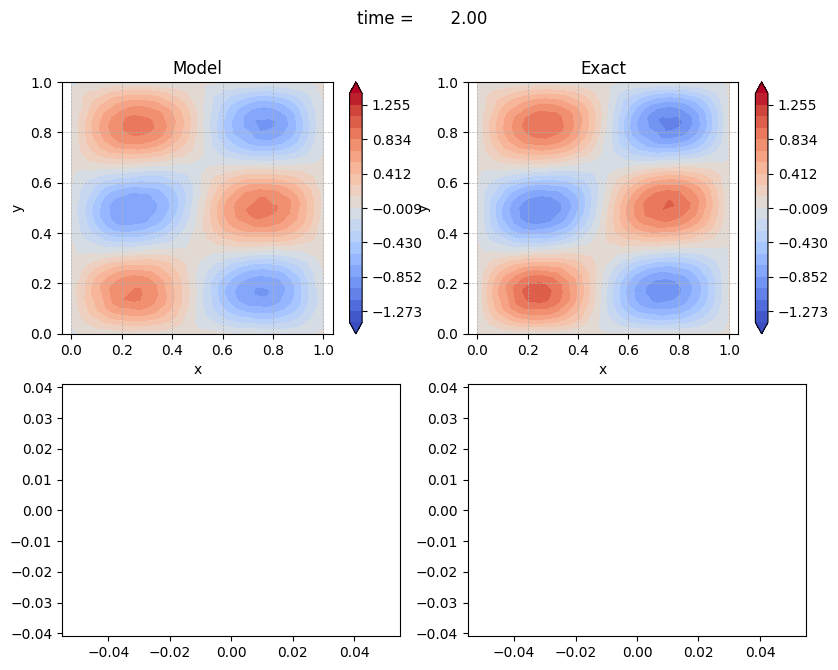

In [13]:
def polish_and_export_plot(
        ax, 
        title=None, 
        xlabel=None, 
        ylabel=None, 
        show_legend=True, 
        save_path: Path | None = None,
        dpi=300):
    
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if show_legend and ax.get_legend_handles_labels()[0]:
        ax.legend(loc='upper right')

    ax.grid(True, ls="--", lw=0.5, zorder=0)
    #ax.spines["top"].set_visible(False)
    #ax.spines["right"].set_visible(False)

    if save_path is not None:
        fig = ax.figure
        fig.tight_layout()
        fig.savefig(save_path.with_suffix(".png"), dpi=dpi)
        fig.savefig(save_path.with_suffix(".svg"))
        fig.savefig(save_path.with_suffix(".eps"))

n_train_points = training_params.n_train_points
batch_size =     training_params.batch_size
n_grad_steps =   training_params.n_epochs * (n_train_points // batch_size)

u_exact = my_bvp.u_exact
is_spatial = isinstance(my_bvp, ISpatial)
is_time_dependent = isinstance(my_bvp, ITemporal)
spatial_domain = my_bvp.spatial_domain if is_spatial else None
temporal_domain = my_bvp.temporal_domain if is_time_dependent else None

problem_dim = my_bvp.problem_dim

results_dir = my_coach.results_dir

model = model.to('cpu')

# ВИЗУАЛИЗАЦИЯ НЕЙРОСЕТЕВОГО РЕШЕНИЯ
with torch.no_grad():
    # Для одномерных задач
    if problem_dim == 1:
        domain = spatial_domain if is_spatial else temporal_domain

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[2.0 * s for s in plt.rcParams['figure.figsize']])
        axes = axes.flatten()

        x = torch.linspace(domain[0], domain[1], 1000).reshape(-1, 1)
        u_approx = model(x)
        u = my_bvp.u_exact(x)
        x1 = x[1:] if is_time_dependent else x[1:-1]
        x1 = x1.clone().detach().requires_grad_(True)
        x2 = x[0:1] if is_time_dependent else x[[0, -1]]
        x2 = x2.clone().detach().requires_grad_(True)
        with torch.enable_grad():
            res = torch.cat( (my_bvp.get_res_domain(model, x1), 
                              my_bvp.get_res_bc(model, x2) if is_spatial else torch.tensor([]),
                              my_bvp.get_res_ic(model, x2) if is_time_dependent else torch.tensor([])), dim=0 )

        axes[0].plot(x, u_approx)
        polish_and_export_plot(axes[0], xlabel="x" if is_spatial else "t", ylabel="u", title="Model")
        axes[1].plot(x, u)
        polish_and_export_plot(axes[1], xlabel="x" if is_spatial else "t", ylabel="u", title="Exact")
        axes[2].plot(x, u_approx - u)
        polish_and_export_plot(axes[2], xlabel="x" if is_spatial else "t", ylabel="err", title="Error")
        axes[3].plot(x, res)
        polish_and_export_plot(axes[3], xlabel="x" if is_spatial else "t", ylabel="res", title="Residual", save_path=results_dir / "solution")

    # Для двумерных задач
    if problem_dim == 2:
        x_domain = my_bvp.sample_domain(4096)
        x_bc = my_bvp.sample_bc(2048)
        x_ic = my_bvp.sample_ic(1024) if is_time_dependent else torch.tensor([])
        x = torch.cat( (x_domain, x_bc, x_ic), dim=0 )
        triang = tri.Triangulation(x[:, 0], x[:, 1])

        u_approx = model(x).squeeze()
        u = my_bvp.u_exact(x).squeeze()

        with torch.enable_grad():
            res_domain = my_bvp.get_res_domain(model, x_domain.clone().detach().requires_grad_(True))
            res_bc = my_bvp.get_res_bc(model, x_bc.clone().detach().requires_grad_(True))
            res_ic = my_bvp.get_res_ic(model, x_ic.clone().detach().requires_grad_(True))[0] if is_time_dependent else torch.tensor([])
            res = torch.cat( (res_domain, res_bc, res_ic), dim=0 ).squeeze()

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[2.0 * s for s in plt.rcParams['figure.figsize']])
        axes = axes.flatten()

        tcf = [None] * 4
        tcf[0] = axes[0].tricontourf(triang, u_approx, levels=80, extend='both', cmap='coolwarm')
        fig.colorbar(tcf[0])
        polish_and_export_plot(axes[0], xlabel="t" if is_time_dependent else "x", ylabel="x" if is_time_dependent else "y", title="Model")

        tcf[1] = axes[1].tricontourf(triang, u, levels=80, extend='both', cmap='coolwarm')
        fig.colorbar(tcf[1])
        polish_and_export_plot(axes[1], xlabel="t" if is_time_dependent else "x", ylabel="x" if is_time_dependent else "y", title="Exact")

        tcf[2] = axes[2].tricontourf(triang, u - u_approx, levels=80, extend='both', cmap='coolwarm')
        fig.colorbar(tcf[2])
        polish_and_export_plot(axes[2], xlabel="t" if is_time_dependent else "x", ylabel="x" if is_time_dependent else "y", title="Error")

        tcf[3] = axes[3].tricontourf(triang, res, levels=80, extend='both', cmap='coolwarm')
        fig.colorbar(tcf[3])
        polish_and_export_plot(axes[3], xlabel="t" if is_time_dependent else "x", ylabel="x" if is_time_dependent else "y", title="Residual", save_path=results_dir / "solution")

    # Для трёхмерных задач
    if problem_dim == 3:
        if is_time_dependent:
            # Пределы задачи
            x_min, y_min, x_max, y_max = spatial_domain
            t_min, t_max = temporal_domain

            # Сэмплирование точек
            x_domain = my_bvp.sample_domain(1024)
            x_bc = my_bvp.sample_bc(1024)
            x = torch.cat( (x_domain, x_bc), dim=0 )

            # Задать объект записи видео
            fps = 30
            writer = anim.FFMpegWriter(
                fps=fps, 
                codec='libx264', 
                extra_args=[
                    '-pix_fmt', 'yuv420p',
                    '-preset', 'ultrafast',
                    "-threads","0"])
            
            # Выяснить максимум и минимум решения, ошибки и вычета
            u_max = -torch.inf
            u_min = torch.inf
            err_max = -torch.inf
            err_min = torch.inf
            res_max = -torch.inf
            res_min= torch.inf
            for time in np.linspace(t_min, t_max, int((t_max - t_min) * fps) ):
                x[:, 0] = torch.ones(x.shape[0]) * time
                u = my_bvp.u_exact(x)
                # err = u - model(x)
                # with torch.enable_grad():
                #     res = my_bvp.get_res_domain(model, x.detach().requires_grad_(True))

                tmp = u.max()
                u_max = tmp if tmp > u_max else u_max
                tmp = u.min()
                u_min = tmp if tmp < u_min else u_min

                # tmp = err.max()
                # err_max = tmp if tmp > err_max else err_max
                # tmp = err.min()
                # err_min = tmp if tmp < err_min else err_min

                # tmp = res.max()
                # res_max = tmp if tmp > res_max else res_max
                # tmp = res.min()
                # res_min = tmp if tmp < res_min else res_min

            triang = tri.Triangulation(x[:, 1], x[:, 2])
            levels_u = np.linspace(u_min, u_max, 21)
            levels_err = 21
            levels_res = 21
            #levels_err = np.linspace(err_min, err_max, 81)
            #levels_res = np.linspace(res_min, res_max, 81)

            fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[1.5 * s for s in plt.rcParams['figure.figsize']])
            axes = axes.flatten()
            for ax in axes:
                ax.axis("equal")
            tcf = [None] * 4
            with writer.saving(fig, results_dir / "model_output.mp4", dpi=150):
                for time in np.linspace(t_min, t_max, int((t_max - t_min) * fps) ):
                    fig.suptitle(f"time = {time:10.2f}")

                    x[:, 0] = torch.ones(x.shape[0]) * time
                    u_approx = model(x).squeeze()
                    u = my_bvp.u_exact(x).squeeze()
                    with torch.enable_grad():
                        if time == t_min:
                            res = my_bvp.get_res_ic(model, x.detach().requires_grad_(True))[0]
                        else:
                            x_domain[:, 0] = torch.ones(x_domain.shape[0]) *time
                            x_bc[:, 0] = torch.ones(x_bc.shape[0]) * time
                            res_domain = my_bvp.get_res_domain(model, x_domain.detach().requires_grad_(True))
                            res_bc = my_bvp.get_res_bc(model, x_bc.detach().requires_grad_(True))
                            res = torch.cat( (res_domain, res_bc), dim=0 )

                    tcf[0] = axes[0].tricontourf(triang, u_approx, levels=levels_u, extend='both', cmap='coolwarm')
                    polish_and_export_plot(axes[0], xlabel="x", ylabel="y", title="Model")
                    tcf[1] = axes[1].tricontourf(triang, u, levels=levels_u, extend='both', cmap='coolwarm')
                    polish_and_export_plot(axes[1], xlabel="x", ylabel="y", title="Exact")
                    #tcf[2] = axes[2].tricontourf(triang, u - u_approx, levels=levels_err, extend='both', cmap='coolwarm')
                    #polish_and_export_plot(axes[2], xlabel="x", ylabel="y", title="Error")
                    #tcf[3] = axes[3].tricontourf(triang, res.squeeze(), levels=levels_res, extend='both', cmap='coolwarm')
                    #polish_and_export_plot(axes[3], xlabel="x", ylabel="y", title="Residual")

                    if time == t_min:
                        fig.colorbar(tcf[0])
                        fig.colorbar(tcf[1])
                        #fig.colorbar(tcf[2])
                        #fig.colorbar(tcf[3])

                    writer.grab_frame()
                    print(f"t = {time:10.2f}, u_min = {u_approx.min():10.2f}, u_max = {u_approx.max():10.2f}")

                    #for t in tcf:
                    #    for coll in t.collections:
                    #        coll.remove()
        else:
            raise ValueError("Visualization for stationary three-dimentional problems has not been implemented yet!")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


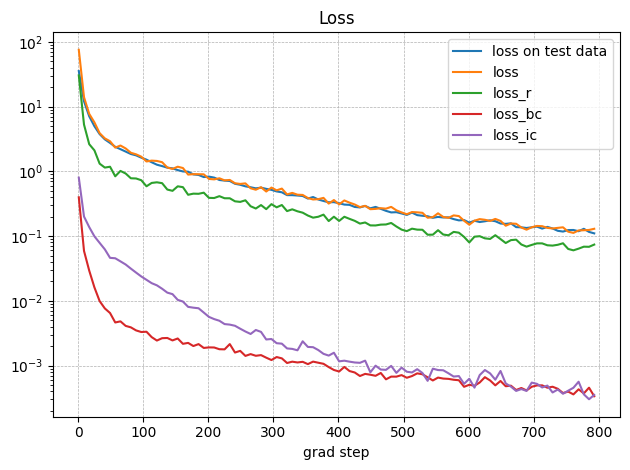

In [14]:
id = np.arange(0, n_grad_steps, n_train_points // batch_size)
#id = np.arange(800, 1000, 1)
grad_steps_array = np.arange(1, n_grad_steps + 1)

with torch.no_grad():
    # # Loss_test
    # fig, ax = plt.subplots()
    # ax.semilogy(grad_steps_array[id], tm.data['loss_test'][id], label="loss_test")
    # ax.semilogy(grad_steps_array[id], tm.data['loss_r_test'][id], label="loss_r_test")
    # if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['loss_bc_test'][id], label="loss_bc_test")
    # if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['loss_ic_test'][id], label="loss_ic_test")
    # polish_and_export_plot(ax, title="Loss_test", xlabel='grad step', save_path=results_dir / "loss_test")
    # plt.show()

    # Loss
    fig, ax = plt.subplots()
    ax.semilogy(grad_steps_array[id], tm.data['loss_test'][id], label="loss on test data")
    ax.semilogy(grad_steps_array[id], tm.data['loss'][id], label="loss")
    ax.semilogy(grad_steps_array[id], tm.data['loss_r'][id], label="loss_r")
    if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['loss_bc'][id], label="loss_bc")
    if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['loss_ic'][id], label="loss_ic")
    polish_and_export_plot(ax, title="Loss", xlabel='grad step', save_path=results_dir / "loss")
    plt.show()

    if is_time_dependent and training_params.use_causal_weighting_scheme:
        # Temporal weights
        fig, ax = plt.subplots()
        for i in range(1, training_params.causal_weighting_M, 1): # w_0 всегда равен 1
            ax.plot(tm.data[f'w_{i:d}'][id], label=f'w_{i:d}')
        polish_and_export_plot(ax, title="Temporal weights", xlabel='grad step', save_path=results_dir / "temporal_weights")

        # loss_r_i
        fig, ax = plt.subplots()
        for i in range(training_params.causal_weighting_M):
            ax.semilogy(tm.data[f'loss_r_{i:d}'][id], label=f'loss_r_{i:d}')
        polish_and_export_plot(ax, title="partial loss_r", xlabel='grad step', save_path=results_dir / "loss_r_i")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


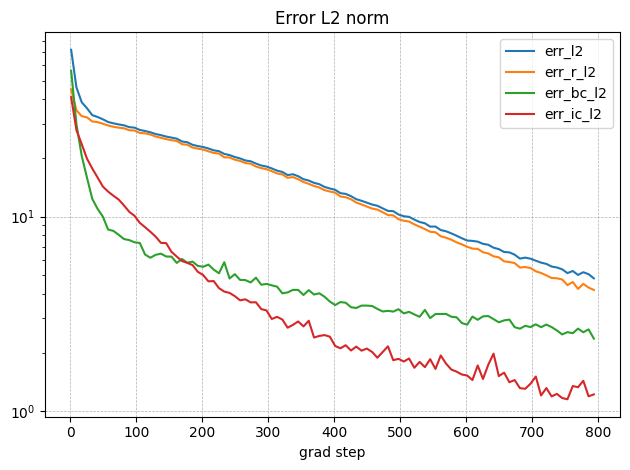

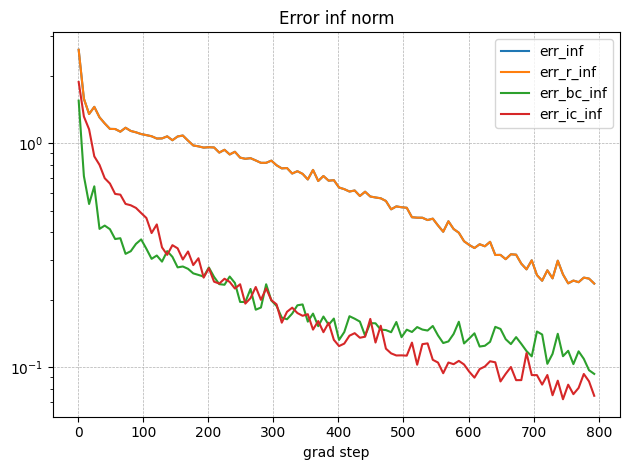

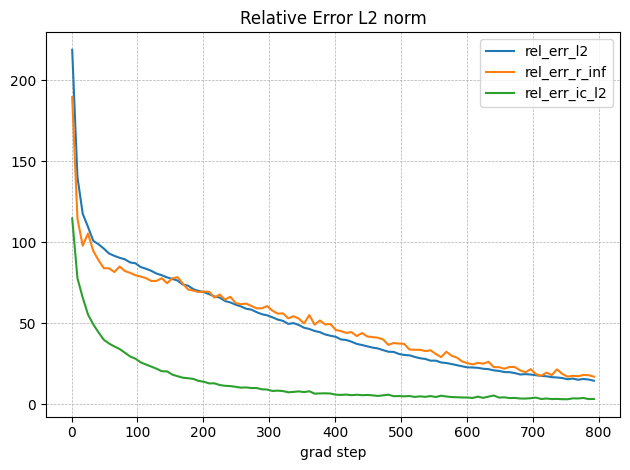

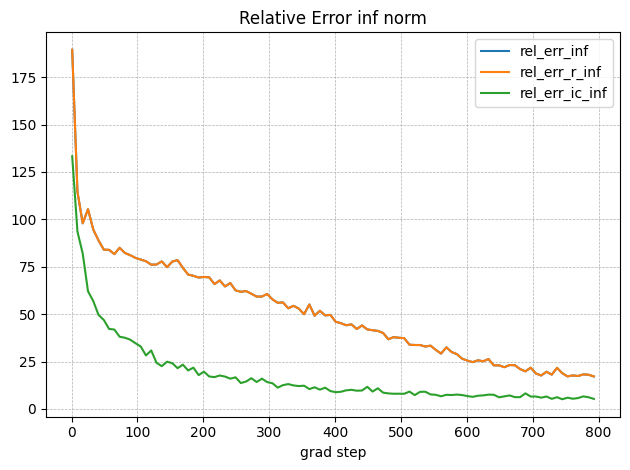

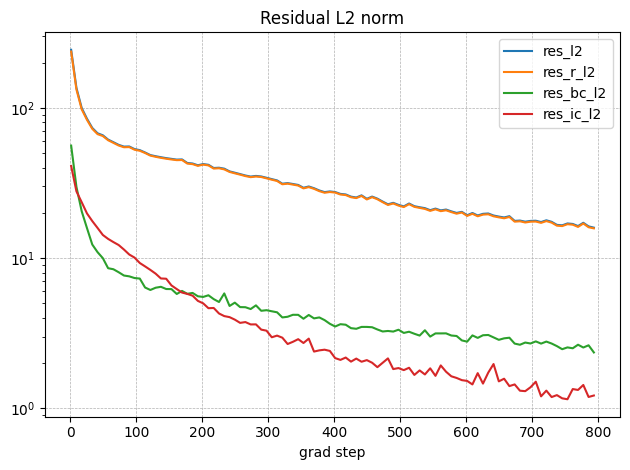

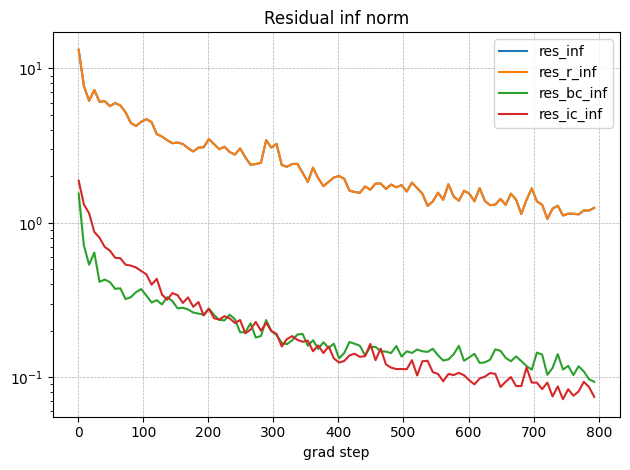

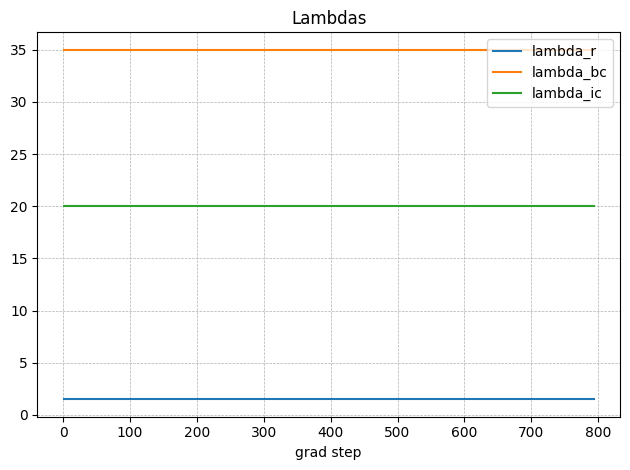

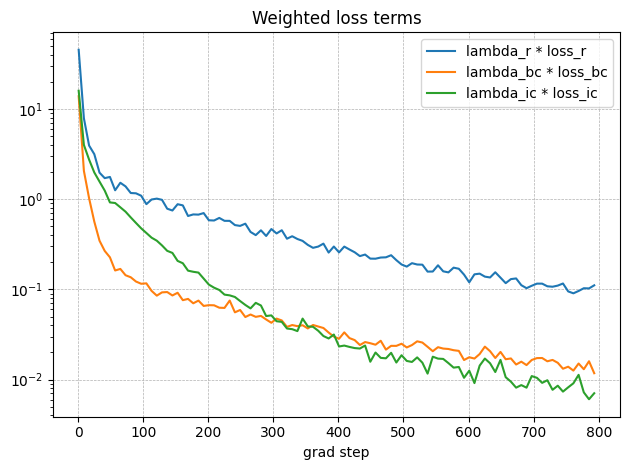

In [15]:
with torch.no_grad():
    # Error L2 norm
    fig, ax = plt.subplots()
    ax.semilogy(grad_steps_array[id], tm.data['err_l2'][id], label="err_l2")
    ax.semilogy(grad_steps_array[id], tm.data['err_r_l2'][id], label="err_r_l2")
    if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['err_bc_l2'][id], label="err_bc_l2")
    if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['err_ic_l2'][id], label="err_ic_l2")
    polish_and_export_plot(ax, title="Error L2 norm", xlabel='grad step', save_path=results_dir / "error_l2")

    # Error inf norm
    fig, ax = plt.subplots()
    ax.semilogy(grad_steps_array[id], tm.data['err_inf'][id], label="err_inf")
    ax.semilogy(grad_steps_array[id], tm.data['err_r_inf'][id], label="err_r_inf")
    if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['err_bc_inf'][id], label="err_bc_inf")
    if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['err_ic_inf'][id], label="err_ic_inf")
    polish_and_export_plot(ax, title="Error inf norm", xlabel='grad step', save_path=results_dir / "error_inf")

    # Relative error L2 norm
    fig, ax = plt.subplots()
    ax.plot(grad_steps_array[id], tm.data['rel_err_l2'][id], label="rel_err_l2")
    ax.plot(grad_steps_array[id], tm.data['rel_err_r_inf'][id], label="rel_err_r_inf")
    if is_spatial and np.max(tm.data['rel_err_bc_l2'][id]) < 1e6: ax.plot(grad_steps_array[id], tm.data['rel_err_bc_l2'][id], label="rel_err_bc_l2")
    if is_time_dependent and np.max(tm.data['rel_err_ic_l2'][id]) < 1e6: ax.plot(grad_steps_array[id], tm.data['rel_err_ic_l2'][id], label="rel_err_ic_l2")
    polish_and_export_plot(ax, title="Relative Error L2 norm", xlabel='grad step', save_path=results_dir / "rel_error_l2")

    # Relative error inf norm
    fig, ax = plt.subplots()
    ax.plot(grad_steps_array[id], tm.data['rel_err_inf'][id], label="rel_err_inf")
    ax.plot(grad_steps_array[id], tm.data['rel_err_r_inf'][id], label="rel_err_r_inf")
    if is_spatial and np.max(tm.data['rel_err_bc_inf'][id]) < 1e6: ax.plot(grad_steps_array[id], tm.data['rel_err_bc_inf'][id], label="rel_err_bc_inf")
    if is_time_dependent and np.max(tm.data['rel_err_ic_inf'][id]) < 1e6: ax.plot(grad_steps_array[id], tm.data['rel_err_ic_inf'][id], label="rel_err_ic_inf")
    polish_and_export_plot(ax, title="Relative Error inf norm", xlabel='grad step', save_path=results_dir / "rel_error_inf")

    # Residual L2 norm
    fig, ax = plt.subplots()
    ax.semilogy(grad_steps_array[id], tm.data['res_l2'][id], label="res_l2")
    ax.semilogy(grad_steps_array[id], tm.data['res_r_l2'][id], label="res_r_l2")
    if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['res_bc_l2'][id], label="res_bc_l2")
    if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['res_ic_l2'][id], label="res_ic_l2")
    polish_and_export_plot(ax, title="Residual L2 norm", xlabel='grad step', save_path=results_dir / "res_l2")

    # Residual inf norm
    fig, ax = plt.subplots()
    ax.semilogy(grad_steps_array[id], tm.data['res_inf'][id], label="res_inf")
    ax.semilogy(grad_steps_array[id], tm.data['res_r_inf'][id], label="res_r_inf")
    if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['res_bc_inf'][id], label="res_bc_inf")
    if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['res_ic_inf'][id], label="res_ic_inf")
    polish_and_export_plot(ax, title="Residual inf norm", xlabel='grad step', save_path=results_dir / "res_inf")

    # Lambdas
    fig, ax = plt.subplots()
    ax.plot(grad_steps_array[id], tm.data['lambda_r'][id], label="lambda_r")
    if is_spatial: ax.plot(grad_steps_array[id], tm.data['lambda_bc'][id], label="lambda_bc")
    if is_time_dependent: ax.plot(grad_steps_array[id], tm.data['lambda_ic'][id], label="lambda_ic")
    polish_and_export_plot(ax, title="Lambdas", xlabel='grad step', save_path=results_dir / "lambdas")

    # Weighted loss terms
    fig, ax = plt.subplots()
    ax.semilogy(grad_steps_array[id], tm.data['lambda_r'][id] * tm.data['loss_r'][id], label="lambda_r * loss_r")
    if is_spatial: ax.semilogy(grad_steps_array[id], tm.data['lambda_bc'][id] * tm.data['loss_bc'][id], label="lambda_bc * loss_bc")
    if is_time_dependent: ax.semilogy(grad_steps_array[id], tm.data['lambda_ic'][id] * tm.data['loss_ic'][id], label="lambda_ic * loss_ic")
    polish_and_export_plot(ax, title="Weighted loss terms", xlabel='grad step', save_path=results_dir / "Weighted_loss_terms")


plt.show()